# Topic time series engineering

This Jupyter Notebook contains the engineering that takes the topics from the clustering as input and creates time series from it. Those time series can then be used as features for the time series forecasting of index funds.

This process is copied to timeseries_engineering.py after initial debugging. It will be extended there.


In [2]:
# Add the repo to the python paths if not yet existing there - for the data_engineering input
import sys
import os

repo_path = os.getcwd().split('project_submission_haiperformer')[0] + 'project_submission_haiperformer'
sys.path.append(repo_path) if repo_path not in sys.path else None

In [4]:
import pandas as pd
from data_engineering.src.util.timeseries_engineering_helpers import normalize_datetime

In [5]:
file_name = "data_lda_model_topics_1000_passes_20_cnbc_news_dataset_processed.csv"
df = pd.read_csv(
    f"../../modelling/output_data/{file_name}", low_memory=False, index_col=0
)
df.head()

,published_at,topic_class
0,2021-09-29T17:09:39+0000,"[(449, 0.09099977), (561, 0.091001034), (753, ..."
1,2016-06-24T13:50:48-0400,"[(488, 0.046972986), (562, 0.92542994), (658, ..."
2,2014-03-25T13:29:45-0400,"[(530, 0.9982684)]"
3,2009-04-22T19:49:03+0000,"[(161, 0.03850209), (164, 0.09252543), (196, 0..."
4,2018-04-14T14:59:04+0000,NaN


In [10]:
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)

# Datetime objs are normalized to be at midnight
df['published_at'] = df['published_at'].apply(normalize_datetime)

min_date = df['published_at'].min()
max_date = df['published_at'].max()

df.set_index('published_at', inplace=True)

date_range = pd.date_range(min_date, max_date, freq='D')

In [ ]:
date_range

DatetimeIndex(['2006-12-04 00:00:00+00:00', '2006-12-05 00:00:00+00:00',
               '2006-12-06 00:00:00+00:00', '2006-12-07 00:00:00+00:00',
               '2006-12-08 00:00:00+00:00', '2006-12-09 00:00:00+00:00',
               '2006-12-10 00:00:00+00:00', '2006-12-11 00:00:00+00:00',
               '2006-12-12 00:00:00+00:00', '2006-12-13 00:00:00+00:00',
               ...
               '2021-10-09 00:00:00+00:00', '2021-10-10 00:00:00+00:00',
               '2021-10-11 00:00:00+00:00', '2021-10-12 00:00:00+00:00',
               '2021-10-13 00:00:00+00:00', '2021-10-14 00:00:00+00:00',
               '2021-10-15 00:00:00+00:00', '2021-10-16 00:00:00+00:00',
               '2021-10-17 00:00:00+00:00', '2021-10-18 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=5433, freq='D')

In [11]:
accumulated_scores = pd.DataFrame(index=date_range)

for index, row in df.iterrows():

    if pd.notna(row['topic_class']):
        topic_class = eval(row['topic_class'])
    else:
        continue

    # Accumulate the scores for each topic number
    for topic, score in topic_class:
        if topic in accumulated_scores.columns:
            if index in accumulated_scores.index:
                accumulated_scores.loc[index, topic] = accumulated_scores.loc[index, topic] + score
            else:
                accumulated_scores.loc[index, topic] = score
        else:
            accumulated_scores[topic] = 0
            accumulated_scores.loc[index, topic] = score

# Fill missing values with 0
accumulated_scores.fillna(0, inplace=True)

In [13]:
accumulated_scores.head()

,449,561,753,756,801,938,488,562,658,530,...,635,962,241,201,187,316,749,957,114,590
2006-12-04 19:51:48+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-05 19:51:48+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-06 19:51:48+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-07 19:51:48+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-12-08 19:51:48+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
accumulated_scores.to_csv(f"../timeseries_data/ts_{file_name}", index=True)

### Visualization

In [12]:
import matplotlib.pyplot as plt

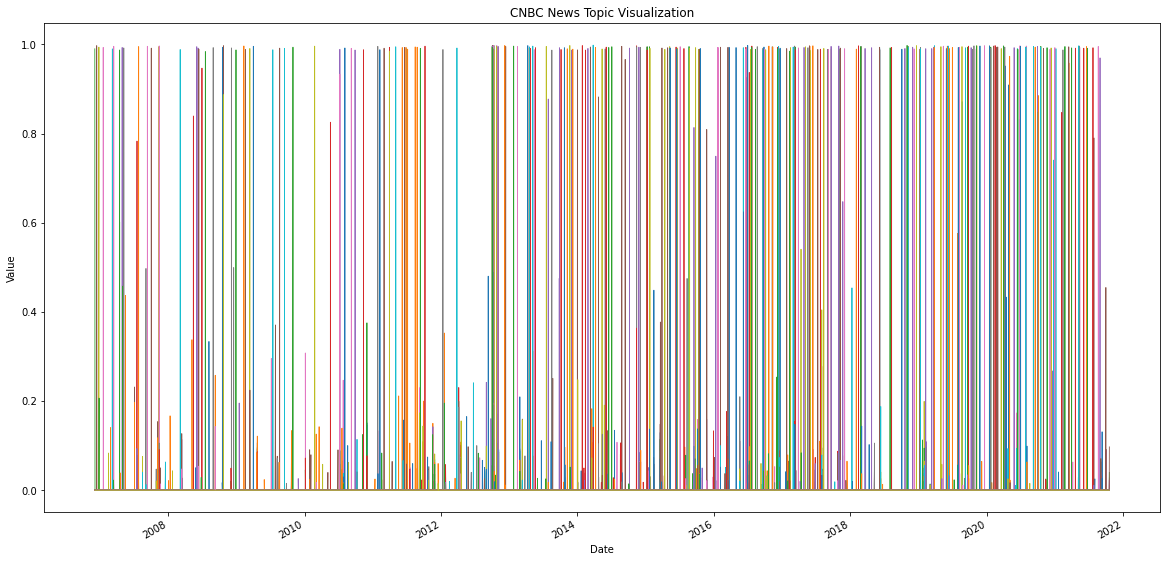

In [14]:
plt.rcParams["figure.figsize"] = [20, 10]
accumulated_scores.plot(lw=0.8)
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("CNBC News Topic Visualization")
plt.legend().remove()
plt.show()